# 環境確認

In [1]:
import sys
import torch

print("Pythonのバージョン：",sys.version)
print("PyTorchのバージョン：", torch.__version__)
print("使用しているGPUの確認")
!nvidia-smi

Pythonのバージョン： 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]
PyTorchのバージョン： 1.10.0+cu111
使用しているGPUの確認
Fri Apr  1 09:01:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----

# データのダウンロード

In [2]:
!pip install kaggle

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [4]:
!kaggle competitions download -c digit-recognizer

 91% 14.0M/15.3M [00:00<00:00, 145MB/s]
100% 15.3M/15.3M [00:00<00:00, 154MB/s]


In [5]:
!ls

digit-recognizer.zip  sample_data


In [6]:
!unzip digit-recognizer.zip

Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# 事前準備

In [7]:
# ライブラリのインポート
import os
import random
from glob import glob
from warnings import filterwarnings

import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import cv2
from PIL import Image

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

from collections import defaultdict

filterwarnings('ignore')  # warningをオフにする

# ランダムシードの設定
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [8]:
# 初期設定
COLAB_FLG = True  # COLABで実行する場合はTrue, それ以外で実行する場合はFalse

if COLAB_FLG:
    from google.colab import drive
    drive.mount('/content/gdrive') # マウント先
    ATTACH_PATH = '/content/gdrive/MyDrive/mnist_pytorch'  # 保存先のベースディレクトリ
else:
    ATTACH_PATH = '.'  # ローカルならカレントディレクトリ
    
    
SAVE_MODEL_PATH = f'{ATTACH_PATH}/model/'  # モデルの保存先

# 保存先のディレクトリを作成する
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)

Mounted at /content/gdrive


In [9]:
# デバイスの設定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {} # GPUが使える場合、DataLoaderでのミニバッチの取り出しを高速化
print(f'デバイス：{device}')

デバイス：cuda


In [10]:
# 定数の設定
pretrained = True

# モデル名
model_name = 'mobilenet_v3_large'

In [11]:
# ハイパーパラメータの設定
parser = argparse.ArgumentParser()
parser.add_argument('--test_size', type=float, default=0.3)
parser.add_argument('--image_size', type=int, default=28)
parser.add_argument('--num_classes', type=int, default=10)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--batch_size', type=int, default=16)
parser.add_argument('--lr', type=float, default=1e-4) # 学習率
parser.add_argument('--patience', type=int, default=10) # earlystoppingの監視対象回数
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=16, epochs=100, image_size=28, lr=0.0001, num_classes=10, patience=10, test_size=0.3)


# Dataset, Dataloader

In [12]:
# データの読み込み
train_df = pd.read_csv('train.csv')
print(train_df.head())
print('データ数: ', train_df.shape[0])

# 学習データと検証データに分割
train, val = train_test_split(train_df, test_size=opt.test_size, random_state=42, stratify=train_df['label'])
print(train.head())
print('学習データ: ', train.shape[0])
print('検証データ: ', val.shape[0])

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [13]:
# transformの設定
transform = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        #transforms.RandomRotation(degrees=20),
        transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        ]),
}

In [14]:
# Dataset
class MNISTDataset(Dataset):
    def __init__(self, df, transform=None, phase=None):
        self.df = df
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        
        # index番目の画像を読み込み、前処理を行う
        data = self.df.iloc[index]
        image = data[1:].values.reshape((28,28)).astype(np.uint8)
        image = self.transform[self.phase](image)
        
        # index番目のラベルを取得する
        label = data[0]

        return image, label

In [15]:
# Datasetのインスタンス作成
train_dataset = MNISTDataset(df=train, transform=transform, phase='train')
val_dataset = MNISTDataset(df=val, transform=transform, phase='val')

In [16]:
# Dataloader
dataloader = {
    'train': DataLoader(train_dataset, batch_size=opt.batch_size, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=opt.batch_size, shuffle=False)
}

torch.Size([16, 1, 28, 28])
tensor([4, 7, 5, 8, 5, 1, 3, 6, 6, 8, 0, 1, 4, 8, 5, 3])
ラベル 4


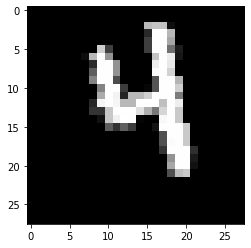

In [17]:
# 画像の確認
train_iter = iter(dataloader['train'])
imgs, labels = train_iter.next()
print(imgs.size())
print(labels)

# imgsの最初の画像の表示
img = imgs[0].reshape((28,28))
plt.imshow(img, cmap='gray')
print('ラベル', np.array(labels[0]))

# 早期終了判定クラス

In [18]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=0):
        '''
        Parameters:
            patience(int): 監視するエポック数(デフォルトは10)
            verbose(int): 早期終了の出力フラグ
                          出力(1),出力しない(0)        
        '''
        # インスタンス変数の初期化
        # 監視中のエポック数のカウンターを初期化
        self.epoch = 0
        # 比較対象の損失を無限大'inf'で初期化
        self.pre_loss = float('inf')
        # 監視対象のエポック数をパラメーターで初期化
        self.patience = patience
        # 早期終了メッセージの出力フラグをパラメーターで初期化
        self.verbose = verbose
        
    def __call__(self, current_loss):
        '''
        Parameters:
            current_loss(float): 1エポック終了後の検証データの損失
        Return:
            True:監視回数の上限までに前エポックの損失を超えた場合
            False:監視回数の上限までに前エポックの損失を超えない場合
        '''
        # 前エポックの損失より大きくなった場合
        if self.pre_loss < current_loss:
            self.epoch += 1 # カウンターを1増やす
            # 監視回数の上限に達した場合
            if self.epoch > self.patience:
                if self.verbose: # 早期終了のフラグが1の場合
                    print('early stopping') # メッセージを出力
                return True # 学習を終了するTrueを返す
        # 前エポックの損失以下の場合
        else:
            self.epoch = 0               # カウンターを0に戻す
            self.pre_loss = current_loss # 損失の値を更新する
        
        # 監視回数の上限までに前エポックの損失を超えなければ
        # Falseを返して学習を続行する
        # 前エポックの損失を上回るが監視回数の範囲内であれば
        # Falseを返す必要があるので、return文の位置はここであることに注意
        return False

# モデルの定義

In [19]:
model = models.mobilenet_v3_large(pretrained=pretrained)
model.features[0][0] = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
fc_in_features = model.classifier[3].out_features # 最終レイヤー関数の次元数
model.fc = nn.Linear(fc_in_features, opt.num_classes) # 最終レイヤー関数の付け替え
print(model)

# モデルをGPUに送る
model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

In [20]:
# 損失関数と最適化関数の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=opt.lr)

In [21]:
# 損失と精度の履歴を保存するためのdictオブジェクト
history = {'train_loss':[],'train_accuracy':[], 'val_loss':[], 'val_accuracy':[]}

# 早期終了の判定を行うオブジェクトを生成
ers = EarlyStopping(patience=opt.patience, # 監視対象回数
                    verbose=1)  # 早期終了時にメッセージを出力


# 学習モデルの定義
def train_model(model, epochs, loss_fn, optimizer):
    
    # ベストスコアの初期化
    best_loss = np.inf
    
    # エポックループの設定
    for epoch in range(epochs):
        
        # 現在のエポック数の出力
        print(f'Epoch: {epoch+1} / {epochs}')
        print('--------------------------')
        
         # 毎エポック: 学習・検証ループの設定
        for phase in ['train', 'val']:
            
            # 学習モード、検証モードの切替
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            # 損失値のリセット
            epoch_loss = 0.0
            # 正解数
            corrects = 0
            # 予測値リストのリセット
            pred_list = []
            # 正解値リストのリセット
            true_list = []
            
            # dataloaderから、ミニバッチ(batch_size)単位でのデータの読み込み
            for images, labels in dataloader[phase]:
                
                # 入力データ、正解ラベルをモデルと同じdeviceへ移動
                images = images.to(device)
                labels = labels.to(device)
                
                # 勾配情報の初期化
                optimizer.zero_grad()
                
                # 学習時のみ勾配情報を有効に
                with torch.set_grad_enabled(phase=='train'):
                    
                    # モデルによる計算
                    outputs = model(images)
                    # 損失値の計算
                    loss = loss_fn(outputs, labels)
                    # 予測ラベルの算出
                    preds = torch.argmax(outputs, dim=1) # 予測値を出力
                    
                    # 学習時のみ、バックプロパゲーションとパラメータ更新
                    if phase == 'train':
                        
                        # 誤差逆伝播法により勾配の算出
                        loss.backward()
                        # optimizerのパラメータ更新
                        optimizer.step()
                    
                    # 損失値の追加
                    epoch_loss += loss.item() * images.size(0)
                    
                    # 正解数の追加
                    corrects += torch.sum(preds == labels.data)                    
                    
                    # 予測ラベルの追加
                    preds = preds.to('cpu').numpy()
                    pred_list.extend(preds)
                    
                    # 正解ラベルの追加
                    labels = labels.to('cpu').numpy()
                    true_list.extend(labels)
            
            # 1エポック内における損失値の平均
            epoch_loss = epoch_loss / len(dataloader[phase].dataset)
            
            # 正解率の算出
            accuracy = corrects.double() / len(dataloader[phase].dataset)
            accuracy = accuracy.to('cpu').detach().numpy().copy() # Tensor型→Numpy型
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_accuracy'].append(accuracy)
            
            # 各評価スコアの出力
            print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {accuracy:.4f}')
            
            # 検証時、検証スコアとベストスコアの大小比較を行う
            if (phase == 'val') and (epoch_loss < best_loss):
                
                ## 検証スコアが改善した場合のみ以下の処理を行う
                
                # ベストスコアの更新
                best_loss = epoch_loss
                # パラメータの名前を指定
                param_name = f'{SAVE_MODEL_PATH}{model_name}_loss_{epoch_loss:.4f}.pth'
                # パラメータの保存
                torch.save(model, param_name)
        
        # 検証データの損失をEarlyStoppingオブジェクトに渡して早期終了を判定
        if (phase == 'val') and ers(epoch_loss):
            # 監視対象のエポックで損失が改善されなければ学習を終了
            break

In [22]:
# モデルの学習と推論の実行
train_model(model, opt.epochs, criterion, optimizer)

Epoch: 1 / 100
--------------------------
train Loss: 4.3471 Accuracy: 0.3163
val Loss: 1.0867 Accuracy: 0.6697
Epoch: 2 / 100
--------------------------
train Loss: 1.4658 Accuracy: 0.5606
val Loss: 0.5030 Accuracy: 0.8450
Epoch: 3 / 100
--------------------------
train Loss: 0.8627 Accuracy: 0.7260
val Loss: 0.2698 Accuracy: 0.9126
Epoch: 4 / 100
--------------------------
train Loss: 0.5548 Accuracy: 0.8219
val Loss: 0.1631 Accuracy: 0.9475
Epoch: 5 / 100
--------------------------
train Loss: 0.4060 Accuracy: 0.8708
val Loss: 0.1228 Accuracy: 0.9617
Epoch: 6 / 100
--------------------------
train Loss: 0.3112 Accuracy: 0.9015
val Loss: 0.0850 Accuracy: 0.9722
Epoch: 7 / 100
--------------------------
train Loss: 0.2476 Accuracy: 0.9213
val Loss: 0.0792 Accuracy: 0.9763
Epoch: 8 / 100
--------------------------
train Loss: 0.2180 Accuracy: 0.9307
val Loss: 0.0706 Accuracy: 0.9785
Epoch: 9 / 100
--------------------------
train Loss: 0.1889 Accuracy: 0.9409
val Loss: 0.0593 Accuracy:

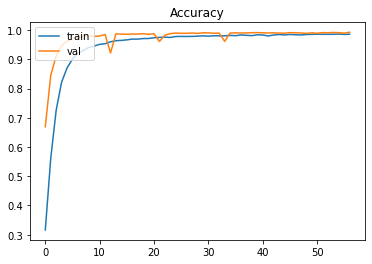

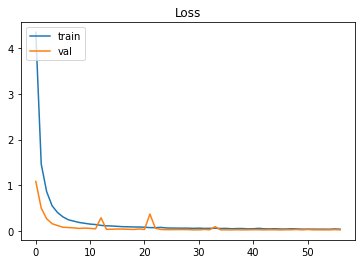

In [23]:
# 正解率の推移をプロット
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# ロスの推移をプロット
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()